## Классификация заголовоков новостей на фейковые и настоящие 

# 0. Установка и подгрузука библиотек
Установка библиотек, под которым запускается данный бейзлайн.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 200)
pd.set_option('display.width', 100)

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, confusion_matrix
from random import sample
import random

import tqdm
from copy import deepcopy
import re

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import logging
logger = logging.getLogger()
logging.disable(logging.ERROR)

from simple_elmo import ElmoModel

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

# 1. Загрузим датасет

In [2]:
data = pd.read_csv("dataset/train.tsv", sep="\t")
data.head(10)

,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмешательство в американские выборы,1
1,Агент Кокорина назвал езду по встречке житейской историей,0
2,Госдума рассмотрит возможность введения секретных статей Уголовного кодекса,1
3,ФАС заблокировала поставку скоростных трамваев для Москвы,0
4,Против Навального завели дело о недоносительстве на Волкова,1
5,Российским студентам запретят учиться за рубежом,1
6,Путин пишет книгу об истории Украины,1
7,Россияне обхитрили рост цен,0
8,Звезда «Ворониных» раскрыл подробности о своем состоянии,0
9,Microsoft объявила дату выхода очков дополненной реальности Hololens,0


In [11]:
submission_data = pd.read_csv("solution.csv", sep=",")
submission_data.head(10)

,title,is_fake
0,Роспотребнадзор призвал мужчин не дарить подарки 8 марта,1
1,Мэнни Пакьяо набрал первое очко в Филиппинской баскетбольной ассоциации,0
2,Два вида игуан Фиджи оказались тремя,1
3,2022 год в России объявлен годом ненависти к врагам,0
4,Американская компания поставит ВМС Ирака девять сторожевых катеров,1
5,В День Победы центр Москвы закроют для гомосексуалистов,1
6,ООН признала «сталинскую» конституцию самой демократичной в истории,1
7,За пятого ребёнка многодетные родители получат автомобиль Tesla,0
8,Путин и Курц подписали меморандум о мирном вхождении Австрии в состав России,0
9,Билли Боб Торнтон снимет роуд-муви,0


* Датасет загружен, проанализируем его содержимое

# 2. Препроцессинг заголовков новостей
1. Токенизация — разобьём каждый заголовок статьи на слова.
2. Нормализация — приведём слова к «рафинированному» виду (единый регистр слов, отсутствие знаков пунктуации, расшифрованные сокращения, словесное написание чисел и т.д.).
3. Стеммизация — приведём слова к его корню путем устранения придатков (суффикса, приставки, окончания).
4. Лемматизация — приведём слова к начальной форме.
5. Чистка — удаленим стоп-слова, которые не несут смысловой нагрузки (артикли, междометья).

* Для этого будем использовать библиотеку pymorphy2

In [13]:
import pymorphy2
count = 0
all_words = []
all_pre_words = []


def sentence_editor(title):
    global count
    txt = re.sub(pattern, "", title)
    txt = txt.strip(" ").lower()
    txt = txt.split() # Tokenizing
    all_pre_words.extend(txt)
    new_txt = []
    for word in txt:
        word = morph.parse(word)[0]
        if word.tag.POS not in ["PRCL", "INTJ", "PREP", "CONJ"]:
            new_txt.append(word.normal_form) # Lemmatizing
        else:
            count += 1
    all_words.extend(new_txt)
    txt = " ".join(new_txt)
    return txt


morph = pymorphy2.MorphAnalyzer()
new_title = []
pattern = "[^а-яА-Яa-zA-Z ё]"

for txt in tqdm.notebook.tqdm(data.title):
    new_title.append(sentence_editor(txt))

start = random.randint(0, len(new_title))
print(*new_title[start:start + 10], sep="\n")
print("DELETED", count, "words")

  0%|          | 0/5758 [00:00<?, ?it/s]

суперкомпьютер предсказать победа лукашенко российский выборы
аутсайдер чемпионат кхл уволить тренер
боб дилан написать шесть книга
соперник россия чемпионат мир хоккей стать швейцария чехия казахстан
белорусский школа начать изучать чучхе
член одкб выбрать сторона киргизотаджикский конфликт метод жеребьёвка
техосмотр отменить только вакцинировать автовладелец
сергей ковалёв показать болельщик соперник средний палец
эрдоган встреча путин назвать крым издревле русский всенародный здравница
майк пенс выступить съезд республиканский партия осуждение культ личность трамп
DELETED 8337 words


In [14]:
new_submission_title = []
pattern = "[^а-яА-Яa-zA-Z ё]"

for txt in tqdm.notebook.tqdm(submission_data.title):
    new_submission_title.append(sentence_editor(txt))

start = random.randint(0, len(new_submission_title))
print(*new_submission_title[start:start + 10], sep="\n")
print("DELETED", count, "words")

  0%|          | 0/5758 [00:00<?, ?it/s]

израиль показать беспилотник россия
госдума первый чтение убрать библия заповедь украсть
обзор рынок повышение учётный ставка обвалить европейский индекс
счётный палата подать тендерный заявка аудит магатэ озхий интерпол
франческо тотти выбыть строй два месяц
мусор мастерская художник бэкон продать миллион фунт
анонсировать гонка forza motorsport
создатель обезьяний остров анонсировать новый игра
россиянин получить бесплатный высокий образование обязать пересдать егэ
оон предоставить талибан рекомендовать стандарт камень свершение гуманный правосудие
DELETED 16674 words


# 3. Визуализация данных


### Есть ли дисбаланс классов?

<AxesSubplot:xlabel='is_fake', ylabel='count'>

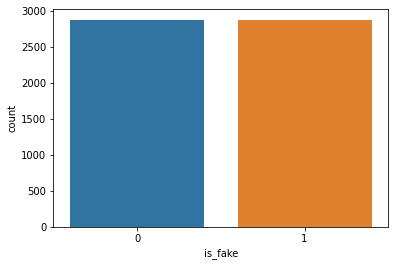

In [15]:
sns.countplot(x=data["is_fake"])

* Колличество фейковых и реальных новостей полностью совпадает, что не может не радовать

### Топ самых частых слов до удаления стоп-слов

In [16]:
NUMBER = 30
count_words = {}
for word in all_pre_words:
    if word in count_words:
        count_words[word] += 1
    else:
        count_words[word] = 1

most_frequency_words = {"word": sorted(count_words, key=lambda x: -count_words[x])[:NUMBER], 
                        "number": []}
for word in most_frequency_words["word"]:
    most_frequency_words["number"].append(count_words[word])


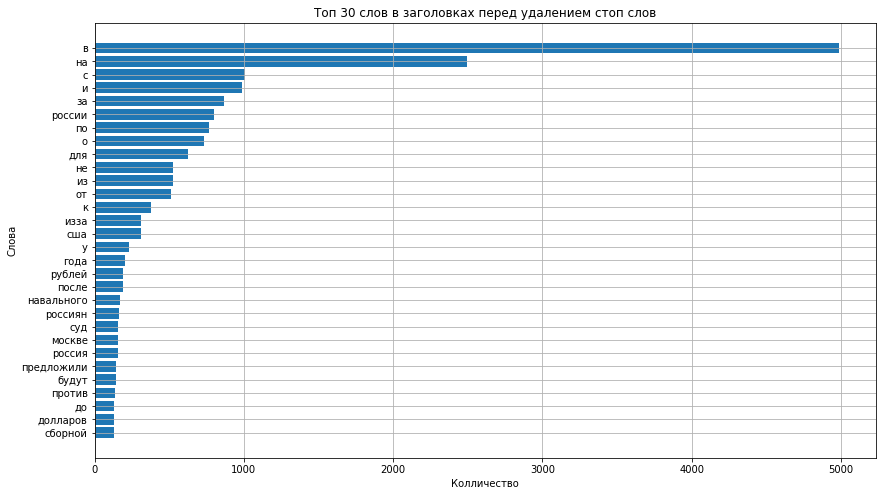

In [17]:
plt.figure(figsize=(14,8))
plt.barh(most_frequency_words["word"][::-1], most_frequency_words["number"][::-1])
plt.ylabel("Слова")
plt.xlabel("Колличество")
plt.title("Топ %d слов в заголовках перед удалением стоп слов" % (NUMBER))
plt.grid(True)

In [18]:
NUMBER = 30
count_words = {}
for word in all_words:
    if word in count_words:
        count_words[word] += 1
    else:
        count_words[word] = 1

most_frequency_words = {"word": sorted(count_words, key=lambda x: -count_words[x])[:NUMBER], 
                        "number": []}
for word in most_frequency_words["word"]:
    most_frequency_words["number"].append(count_words[word])


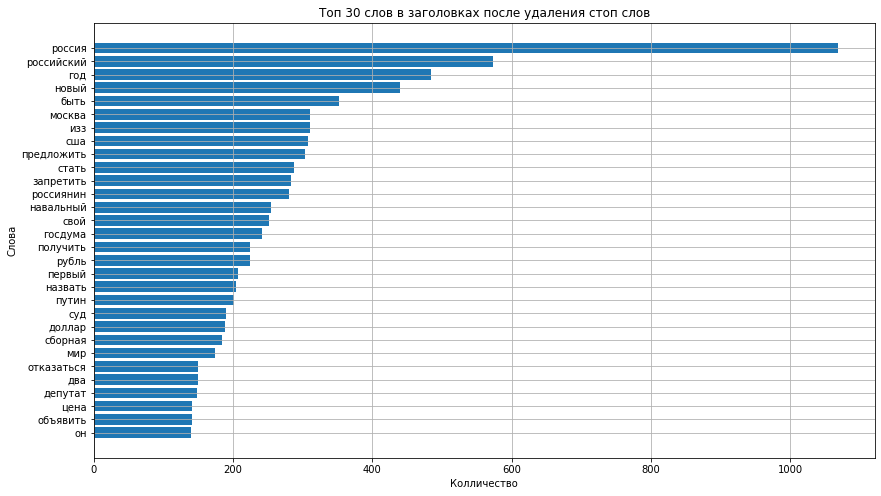

In [19]:
plt.figure(figsize=(14,8))
plt.barh(most_frequency_words["word"][::-1], most_frequency_words["number"][::-1])
plt.ylabel("Слова")
plt.xlabel("Колличество")
plt.title("Топ %d слов в заголовках после удаления стоп слов" % (NUMBER))
plt.grid(True)

# 4. Переведём каждый обработанный заголовок в векторное представление
* с помощью контекстуализированной модели от RusVectōrēs натренерованной на около 10 миллиардов слов
* будем создавать вектор для каждого слова, а в качестве вектора предложения будем брать среднее значение между всеми словами в нём

In [20]:
elmo_model = ElmoModel()
elmo_model.load("sentence_embender")

c:\users\vush6\pycharmprojects\fake or real title of news\venv\lib\site-packages\simple_elmo\model.py:529: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  lstm_cell = tf.compat.v1.nn.rnn_cell.LSTMCell(
c:\users\vush6\pycharmprojects\fake or real title of news\venv\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:984: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._kernel = self.add_variable(
c:\users\vush6\pycharmprojects\fake or real title of news\venv\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:993: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._bias = self.add_variable(
c:\users\vush6\pycharmprojects\fake or real title of

'The model is now loaded.'

In [10]:
new_title[0]

'москвич владимир клутина прийти счёт вмешательство американский выборы'

In [22]:
title_matrix = np.array([[0] * 1024], dtype=float)
batch_size = 32
for i in tqdm.notebook.tqdm(range(0, len(new_title), batch_size)):
    title_matrix = np.append(title_matrix, 
                             elmo_model.get_elmo_vector_average([x.split() for x in new_title[i:i + batch_size]]),
                             axis=0)

title_matrix = np.delete(title_matrix, 0, axis=0)
title_matrix.shape

  0%|          | 0/180 [00:00<?, ?it/s]

(5758, 1024)

In [23]:
submission_title_matrix = np.array([[0] * 1024], dtype=float)
batch_size = 32
for i in tqdm.notebook.tqdm(range(0, len(new_submission_title), batch_size)):
    submission_title_matrix = np.append(submission_title_matrix, 
                             elmo_model.get_elmo_vector_average(
                                 [x.split() for x in new_submission_title[i:i + batch_size]]),
                             axis=0)

submission_title_matrix = np.delete(submission_title_matrix, 0, axis=0)
submission_title_matrix.shape

  0%|          | 0/180 [00:00<?, ?it/s]

(5758, 1024)

In [24]:
print(data.shape)
print(title_matrix.shape)

print(submission_data.shape)
print(submission_title_matrix.shape)

(5758, 2)
(5758, 1024)
(5758, 2)
(5758, 1024)


# 5. Разделим датасет на обучающую, валидационную и тестовую подвыборки

In [36]:
x = np.concatenate((np.array(data.drop("is_fake", axis=1)), title_matrix), axis=1)
y = np.array([np.array(data[data.title == title[0]].is_fake)[0] for title in x])

In [37]:
submission_x = np.concatenate((np.array(submission_data.drop("is_fake", axis=1)), submission_title_matrix), axis=1)
submission_y = np.array([np.array(submission_data[submission_data.title == title[0]].is_fake)[0] 
                         for title in submission_x])

In [38]:
x

array([['Москвичу Владимиру Клутину пришёл счёт за вмешательство в американские выборы',
        -0.026137593794597208, -0.03709144557447718, ...,
        0.019916739216694315, -0.007809336559148129,
        -0.07590965777116687],
       ['Агент Кокорина назвал езду по встречке житейской историей',
        0.0045856463767328754, 0.012149634418496334, ...,
        0.04233165955172, 0.1038698998738525, -0.059589282419974195],
       ['Госдума рассмотрит возможность введения секретных статей Уголовного кодекса',
        0.016818846771092983, -0.08118769593812755, ...,
        -0.0031721681378487033, 0.000560379545336687,
        -0.018380930701067475],
       ...,
       ['«Мне стыдно перед дедом»: новый канцлер ФРГ обратился с первой речью к Бундестагу',
        -0.029480071644749972, -0.04626696189487515, ...,
        0.008875949963536522, 0.015297313644998036,
        -0.026672368018459965],
       ['Туркмения в декабре начнет поставки газа в Китай',
        -0.020441723371993712, -0.0

In [42]:
print(x.shape)
print(y.shape)

(5758, 1025)
(5758,)


In [43]:
from sklearn.model_selection import train_test_split

# Train Test Split
X_train, X_test, Y_train, Y_test = train_test_split(x, np.array(y), test_size=0.15, random_state=1, shuffle=True)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15, random_state=1, shuffle=True)

In [44]:
X_train = np.append(X_train, submission_x, axis=0)
Y_train = np.append(Y_train, submission_y, axis=0)
print(X_train.shape)
print(Y_train.shape)

(9917, 1025)
(9917,)


In [45]:
train_title = [x[0] for x in X_train]
test_title = [x[0] for x in X_test]
val_title = [x[0] for x in X_val]

X_train = np.array([x[1:] for x in X_train], dtype=np.float64)
X_test = np.array([x[1:] for x in X_test], dtype=np.float64)
X_val = np.array([x[1:] for x in X_val], dtype=np.float64)

In [46]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_test.shape)
print(Y_val.shape)

(9917, 1024)
(864, 1024)
(735, 1024)
(9917,)
(864,)
(735,)


# 6. Здесь определяем саму линейную модель

In [47]:
class ANN(nn.Module):
    
    def __init__(self):
        
        super(ANN, self).__init__()
        
        self.linear1 = nn.Linear(1024, 800)
        self.relu1 = nn.ReLU6()
        
        self.linear2 = nn.Linear(800, 600)
        self.relu2 = nn.ReLU6()
        
        self.linear3 = nn.Linear(600, 500)
        self.relu3 = nn.ReLU6()
        
        self.linear4 = nn.Linear(500, 300)
        self.relu4 = nn.ReLU6()
        
        self.linear5 = nn.Linear(300, 100)
        self.relu5 = nn.ReLU6()
        
        self.linear6 = nn.Linear(100, 20)
        self.relu6 = nn.ReLU6()
    
        self.linear7 = nn.Linear(20, 2)
        
    
    def forward(self, x):
        
        out = self.linear1(x)
        out = self.relu1(out)
        
        out = self.linear2(out) 
        out = self.relu2(out)
        
        out = self.linear3(out)
        out = self.relu3(out)
        
        out = self.linear4(out)
        out = self.relu4(out)
        
        out = self.linear5(out)
        out = self.relu5(out)
        
        out = self.linear6(out)
        out = self.relu6(out)
        
        out = self.linear7(out)

        return out

# 7. Переходим к самому скрипту обучения - циклы трейна и валидации

In [48]:
def train_loop(model, optimizer, criterion, X_train, Y_train):
    model.train()
    model.zero_grad()

    optimizer.zero_grad()

    outs = model(X_train)
    loss = criterion(outs, Y_train)

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 2)
    optimizer.step()
    return round(float(loss), 4)


def val_loop(model, X_val, Y_val):
    model.eval()
    test_pred = torch.max(model(X_val), 1)[1]
    return round(float(f1_score(test_pred, Y_val)), 4)
    

def train(X_train, Y_train, X_val, Y_val):
    model = ANN()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=optimizer, mode='max', factor=0.75, patience=15)

    val_f1_score_history = [0]
    best_model = None

    X_train = torch.Tensor(X_train)
    Y_train = torch.Tensor(np.array(Y_train, dtype=np.float64)).type(torch.LongTensor)
    X_val = torch.Tensor(X_val)
    Y_val = torch.Tensor(Y_val)

    EPOCHS = 200
    for epoch in range(EPOCHS):
        loss = train_loop(model, optimizer, criterion, X_train, Y_train)
        f1_score = val_loop(model, X_val, Y_val)
        scheduler.step(f1_score)

        for param_group in optimizer.param_groups:
            lr = param_group['lr']
        print(f"Loss after iteration {epoch} is {loss:.4f}",
              f"val f1-score: {f1_score:.4f}", 
              f"lr: {lr}", sep="    ")

        if f1_score > max(val_f1_score_history) and f1_score > 0.86:
            model_save_path = os.path.join(
                    "save_dir", f'model-{val_f1_score_history[-1]:.4f}.ckpt')
            torch.save(model.state_dict(), model_save_path)
            best_model = deepcopy(model)
            print("MODEL SAVED")
        
        val_f1_score_history.append(f1_score)
    return EPOCHS, val_f1_score_history, best_model


# 8. Запускаем обучение!

In [49]:
EPOCHS, val_f1_score_history, best_model = train(X_train, Y_train, X_val, Y_val)

Loss after iteration 0 is 0.7079    val f1-score: 0.6612    lr: 0.001
Loss after iteration 1 is 0.7054    val f1-score: 0.6612    lr: 0.001
Loss after iteration 2 is 0.7031    val f1-score: 0.6612    lr: 0.001
Loss after iteration 3 is 0.7003    val f1-score: 0.6612    lr: 0.001
Loss after iteration 4 is 0.6966    val f1-score: 0.6612    lr: 0.001
Loss after iteration 5 is 0.6917    val f1-score: 0.7023    lr: 0.001
Loss after iteration 6 is 0.6868    val f1-score: 0.0272    lr: 0.001
Loss after iteration 7 is 0.6871    val f1-score: 0.1432    lr: 0.001
Loss after iteration 8 is 0.6838    val f1-score: 0.5483    lr: 0.001
Loss after iteration 9 is 0.6787    val f1-score: 0.7431    lr: 0.001
Loss after iteration 10 is 0.6758    val f1-score: 0.7982    lr: 0.001
Loss after iteration 11 is 0.6725    val f1-score: 0.7965    lr: 0.001
Loss after iteration 12 is 0.6679    val f1-score: 0.7976    lr: 0.001
Loss after iteration 13 is 0.6634    val f1-score: 0.7970    lr: 0.001
Loss after itera

Loss after iteration 106 is 0.4396    val f1-score: 0.6493    lr: 0.00031640625000000006
Loss after iteration 107 is 0.4319    val f1-score: 0.6437    lr: 0.00031640625000000006
Loss after iteration 108 is 0.4316    val f1-score: 0.6482    lr: 0.00031640625000000006
Loss after iteration 109 is 0.4344    val f1-score: 0.6438    lr: 0.00031640625000000006
Loss after iteration 110 is 0.4316    val f1-score: 0.6459    lr: 0.00031640625000000006
Loss after iteration 111 is 0.4230    val f1-score: 0.6451    lr: 0.00031640625000000006
Loss after iteration 112 is 0.4201    val f1-score: 0.6405    lr: 0.00023730468750000005
Loss after iteration 113 is 0.4230    val f1-score: 0.6434    lr: 0.00023730468750000005
Loss after iteration 114 is 0.4172    val f1-score: 0.6426    lr: 0.00023730468750000005
Loss after iteration 115 is 0.4149    val f1-score: 0.6396    lr: 0.00023730468750000005
Loss after iteration 116 is 0.4164    val f1-score: 0.6411    lr: 0.00023730468750000005
Loss after iteration 

Loss after iteration 199 is 0.3296    val f1-score: 0.6088    lr: 5.631351470947266e-05


* посмотрим на изменение f1-score 

<AxesSubplot:xlabel='epochs', ylabel='f1-score'>

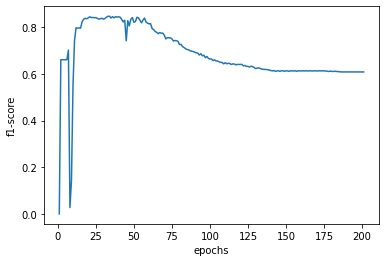

In [50]:
sns.lineplot(data={"f1-score": val_f1_score_history,
                   "epochs": list(range(1, EPOCHS + 2))}, x="epochs", y="f1-score")

# 9. Проверим точность нашей модели на тест части датасета

In [52]:
X_test = torch.Tensor(X_test)

Y_test = torch.Tensor(np.array(Y_test, dtype=np.float64)).type(torch.LongTensor)

best_model.eval()
y_head = best_model(X_test)
y_pred = torch.max(y_head, 1)[1]

for i in sample(list(range(500)), 10):
    print(test_title[i], "pred", y_pred[i].item(), "is_fake", int(Y_test[i].item()))

print("\nModel accuracy is ", f1_score(y_pred, Y_test))
model_plot = input()
if model_plot != "":
    with open("used_models.txt", mode="a") as f:
        f.write(model_plot + ";" + str(EPOCHS) + ";" + str(f1_score(y_pred, Y_test)) + "\n")

AttributeError: 'NoneType' object has no attribute 'eval'

## 10. Создаём предсказания для тестовых данных

In [ ]:
test_data = pd.read_csv("dataset/test.tsv", sep="\t", header=0)
test_data = data.sample(frac=1)

new_title = []
for txt in tqdm.notebook.tqdm(data.title):
    new_title.append(sentence_editor(txt))

title_matrix = np.array([[0] * 1024], dtype=float)
batch_size = 32
for i in tqdm.notebook.tqdm(range(0, len(new_title), batch_size)):
    title_matrix = np.append(title_matrix, 
                             elmo_model.get_elmo_vector_average([x.split() for x in new_title[i:i + batch_size]]), 
                             axis=0)

title_matrix = np.delete(title_matrix, 0, axis=0)
title_matrix.shape

y_head = best_model(torch.Tensor(title_matrix))
y_pred = torch.max(y_head, 1)[1]

test_data.is_fake = y_pred
test_data.to_csv("solution.csv", index=False)

test_data.head(10)

  0%|          | 0/5758 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]